In [1]:
from utils import load_config, normalized_mae_in_pixels
from dataset import PoseDataset
from ultralytics import YOLO
import torch
import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os

In [2]:
class YoloPoseDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=640):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
        self.img_size = img_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(image_path)  # BGR image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load label
        label_path = os.path.join(self.labels_dir, self.image_files[idx].replace('.jpg', '.txt').replace('.png', '.txt'))
        with open(label_path, 'r') as file:
            label_line = file.readline().strip()

        # Parse the keypoints and visibility
        keypoint_data = list(map(float, label_line.split()))
        keypoint_data = keypoint_data[5:]
        num_keypoints = len(keypoint_data) // 3  # x, y, and visibility for each keypoint

        # Extract keypoints and visibility
        keypoints = []
        visibility = []

        for i in range(num_keypoints):
            x = keypoint_data[i * 3]
            y = keypoint_data[i * 3 + 1]
            vis = keypoint_data[i * 3 + 2]
            keypoints.append([x, y])
            visibility.append(vis)

        keypoints = torch.tensor(keypoints, dtype=torch.float32)  # Shape: (num_keypoints, 2)
        keypoints = keypoints * self.img_size
        visibility = torch.tensor(visibility, dtype=torch.float32)

        # resize image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.transpose(2, 0, 1)
        image = torch.tensor(image, dtype=torch.float32) / 255.0

        return image, keypoints, visibility

In [3]:
def get_keypoints_yolo(outputs, num_keypoints=17):
    keypoints = []
    for output in outputs:
        xy = output.keypoints.xy[0]
        if xy.shape[0] < num_keypoints:
            xy = torch.cat((xy, torch.zeros(num_keypoints - xy.shape[0], 2).to(xy.device)))
        keypoints.append(xy)
    
    return torch.stack(keypoints)

In [18]:
# Usage example:
root_dir = './data/YOLO_med_34/val'
images_dir = root_dir + '/images'
labels_dir = root_dir + '/labels'

train = "train6"

img_size = 640

dataset = YoloPoseDataset(images_dir=images_dir, labels_dir=labels_dir, img_size=img_size)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLO(f'./models/YOLO/runs/pose/{train}/weights/best.pt').to(device)

norm_mae = 0
# To iterate through the data
for images, gt_keypoints, visibility in tqdm.tqdm(data_loader):
    images = images.to(device)
    gt_keypoints = gt_keypoints.to(device)
    visibility = visibility.to(device)

    outputs = model(images, verbose=False)
    keypoints = get_keypoints_yolo(outputs, num_keypoints=17)
    norm_mae += normalized_mae_in_pixels(keypoints, gt_keypoints, (img_size, img_size), visibility)
    
    break

norm_mae /= len(data_loader)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:03<?, ?it/s]


In [5]:
print('Normalized MAE:', norm_mae)

Normalized MAE: 2.383003542397885


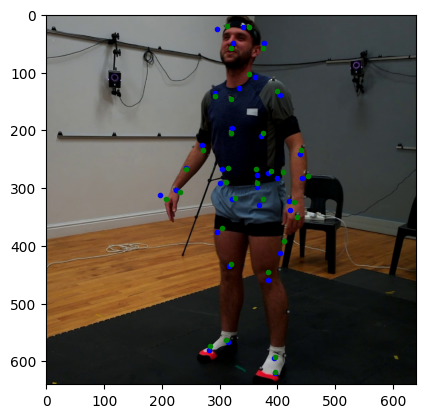

In [23]:
import matplotlib.pyplot as plt

n = 50

image_show = images[n].permute(1,2,0).cpu().numpy().copy()

keypoints_show = keypoints[n].cpu().numpy()
keypoints_gt = gt_keypoints[n].cpu().numpy()

plt.imshow(image_show)
plt.plot(keypoints_show[:,0], keypoints_show[:,1], 'bo', markersize=3)
plt.plot(keypoints_gt[:,0], keypoints_gt[:,1], 'go', markersize=3)
plt.show()